In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))

32033


In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)


In [4]:
block_size = 8 

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


In [ ]:
import random
random.shuffle(words)
n = int(0.8*len(words))

Xtr, Ytr = build_dataset(words[:n])
Xte, Yte = build_dataset(words[n:])


In [ ]:

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True)
      xvar = x.var(dim, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
n_embd = 24 
n_hidden = 128
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
for p in parameters:
  p.requires_grad = True

In [ ]:
batch_size = 32
lri = []
lossi = []
stepi = []

for i in range(20000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) 
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  lr = 0.1 if i < 15000 else 0.01 
  for p in parameters:
    p.data += -lr * p.grad

  stepi.append(i)
  lossi.append(loss.item())
  print(loss.item())


3.317253589630127
3.2655560970306396
3.2219109535217285
3.1884803771972656
3.092963933944702
3.0627095699310303
3.0860724449157715
3.1124308109283447
2.8397181034088135
3.0585789680480957
3.045253038406372
3.2170403003692627
2.852612018585205
2.995675802230835
3.0184483528137207
2.8491036891937256
2.674548387527466
2.9454729557037354
2.6347897052764893
3.1121106147766113
2.7618770599365234
2.979414701461792
3.199138879776001
2.9645578861236572
2.6894724369049072
2.857494831085205
2.9799487590789795
3.0216293334960938
3.0239713191986084
2.8054795265197754
2.8686084747314453
2.8140146732330322
2.9010989665985107
2.9557158946990967
3.0007925033569336
2.8426785469055176
2.8641810417175293
2.79715633392334
2.83743953704834
2.732630729675293
2.9036102294921875
2.7109527587890625
3.0282270908355713
2.9670181274414062
2.7228636741638184
2.737666368484497
2.7705485820770264
3.155599355697632
2.913501024246216
2.6480770111083984
2.6860640048980713
2.608705759048462
2.8069005012512207
2.722007036

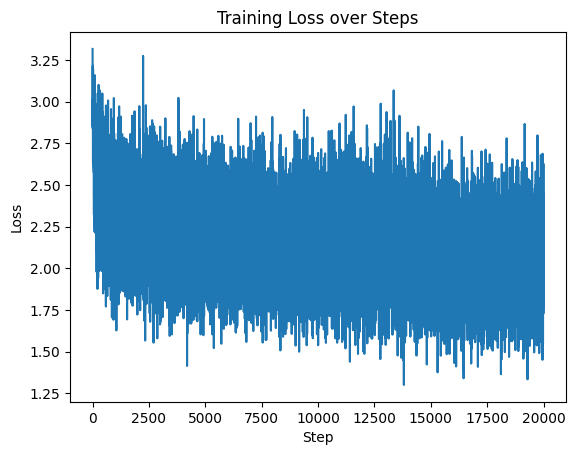

In [ ]:
plt.plot(stepi, lossi)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss over Steps')
plt.show()

In [ ]:
for layer in model.layers:
  layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad() 
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('test')

train 1.9965970516204834
test 2.0417487621307373


In [ ]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size 
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

stalyn.
rexrin.
kalleyta.
rad.
mazak.
zakiel.
zahsyah.
aisha.
jayzen.
mario.
meko.
zaria.
jacavii.
mayah.
shamon.
aasha.
ziana.
muham.
renazy.
urlyn.
